# ライブラリ

In [9]:
import numpy as np
import torch     
import pandas as pd
import math
import pprint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import trange
from tqdm.contrib import tzip,tqdm
#from tqdm.notebook import tqdm
from IPython.display import display

from matplotlib.colors import Normalize
from collections import OrderedDict

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
output_path="density_3d_arrray/density_2410_quarter.pt"

In [11]:
config="config/config0703_nozzle"#.csv

#処理タスクリストを取得
df_config=pd.read_csv("{}.csv".format(str(config)))
df_config=df_config.set_index("experiment")
df_config=df_config[df_config["process_flag"]==1]#処理タスクリストから処理フラグ有効のみを残す

# ラプラシアンを計算

In [12]:
path="reconstructed/reconstructed2410_quater.npy"
array_nabura=np.load(path)
print(array_nabura.shape)
print(array_nabura)

In [ ]:
def compute_laplacian_chunk(array_chunk):
    grad_yy = np.gradient(array_chunk, axis=1)
    grad_zz = np.gradient(array_chunk, axis=2)
    laplacian_chunk = grad_yy + grad_zz
    return laplacian_chunk

def compute_laplacian_in_chunks(array, chunk_size):
    # 配列の形状を取得
    shape = array.shape
    
    # 結果を保存する配列を作成
    laplacian = np.zeros_like(array)
    
    # チャンクごとに処理
    for i in trange(0, shape[0], chunk_size):
        for j in range(0, shape[1], chunk_size):
            for k in range(0, shape[2], chunk_size):
                # チャンクを抽出
                chunk = array[i:i+chunk_size, j:j+chunk_size, k:k+chunk_size]
                
                # チャンクでラプラシアンを計算
                laplacian_chunk = compute_laplacian_chunk(chunk)
                
                # 計算結果を元の配列の対応する位置に保存
                laplacian[i:i+chunk_size, j:j+chunk_size, k:k+chunk_size] = laplacian_chunk
    
    return laplacian

# チャンクサイズを指定して計算
chunk_size = 200
array_laplacian = compute_laplacian_in_chunks(array_nabura, chunk_size)


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


# データローダーをつくる

In [ ]:
batch_size=200#ミニバッチのサイズを指定
array_laplacian_dataloarder=torch.utils.data.DataLoader(torch.tensor(array_laplacian).to(device),batch_size=batch_size,shuffle=False)#シャッフルは切っておく

# SOR法

In [ ]:
Lx=array_laplacian.shape[0]
Ly=array_laplacian.shape[1]
Lz=array_laplacian.shape[2]
x  = Lx
y  = Ly
z  = Lz

In [ ]:
e = 1e-9
tolerance = 1e-24
max_stable_iters = 100000

# メイン
delta = 1.0
n_iter = 0
stable_count = 0
prev_delta = float('inf')
u_list = []


# tqdmのインスタンスを一番上に表示
#progress_bar = tqdm(total=len(array_laplacian_dataloarder))
#display(progress_bar.container)


for batch in tqdm(array_laplacian_dataloarder):  # DataLoaderからバッチを取得
    slice_laplacian = batch.to(device)  # バッチデータをデバイスに移動
    batch_size, Ly, Lz = slice_laplacian.size()
    u = torch.zeros([batch_size, Ly, Lz], device=device)  # uを同じデバイスで作成
    delta = 1.0
    n_iter = 0
    stable_count = 0  # 安定回数のカウンタをリセット
    
    while delta > e and stable_count < max_stable_iters:
        u_in = u.clone()
        u[:, 1:-1, 1:-1] = (u_in[:, 2:, 1:-1] + u_in[:, :-2, 1:-1] +
                            u_in[:, 1:-1, 2:] + u_in[:, 1:-1, :-2] + slice_laplacian[:, 1:-1, 1:-1]) / 4

        u[:, 0, :] = 0
        u[:, Ly-1, :] = 0
        u[:, :, 0] = 0
        u[:, :, Lz-1] = 0
        delta = torch.max(torch.abs(u - u_in))
        
        # 残差の変化をチェック
        if abs(delta - prev_delta) < tolerance:
            stable_count += 1
        else:
            stable_count = 0

        prev_delta = delta

        print(f'Iteration: {n_iter}, Loss: {delta}, Stable Count: {stable_count}')
        n_iter += 1
    
    #progress_bar.update(1)
    u_list.append(u)

u_tensor = torch.cat(u_list, dim=0)  # 最終的な出力をリストからテンソルに変換


  0%|          | 0/8 [00:00<?, ?it/s]

Iteration: 0, Loss: 4.246975549904164e-06, Stable Count: 0
Iteration: 1, Loss: 2.7755390874517616e-06, Stable Count: 0
Iteration: 2, Loss: 2.32233196584275e-06, Stable Count: 0
Iteration: 3, Loss: 1.938694367709104e-06, Stable Count: 0
Iteration: 4, Loss: 1.6684025467839092e-06, Stable Count: 0
Iteration: 5, Loss: 1.4958914107410237e-06, Stable Count: 0
Iteration: 6, Loss: 1.3146709534339607e-06, Stable Count: 0
Iteration: 7, Loss: 1.1986003300989978e-06, Stable Count: 0
Iteration: 8, Loss: 1.1572956282179803e-06, Stable Count: 0
Iteration: 9, Loss: 1.1211714081582613e-06, Stable Count: 0
Iteration: 10, Loss: 1.088381395675242e-06, Stable Count: 0
Iteration: 11, Loss: 1.0593576007522643e-06, Stable Count: 0
Iteration: 12, Loss: 1.0323838068870828e-06, Stable Count: 0
Iteration: 13, Loss: 1.0083895176649094e-06, Stable Count: 0
Iteration: 14, Loss: 9.85488441074267e-07, Stable Count: 0
Iteration: 15, Loss: 9.65133949648589e-07, Stable Count: 0
Iteration: 16, Loss: 9.452523954678327e-07,

  0%|          | 0/8 [00:16<?, ?it/s]

Iteration: 456, Loss: 2.450833562761545e-07, Stable Count: 0
Iteration: 457, Loss: 2.447341103106737e-07, Stable Count: 0
Iteration: 458, Loss: 2.44428520090878e-07, Stable Count: 0
Iteration: 459, Loss: 2.4405017029494047e-07, Stable Count: 0
Iteration: 460, Loss: 2.4375913199037313e-07, Stable Count: 0


KeyboardInterrupt: 

# 密度の計算

In [ ]:
print(u_tensor.shape)

torch.Size([1427, 915, 915])


In [ ]:
exp=df_config.index[0]
temperature=df_config["temperature(℃)"][exp]
pressure=df_config["pressure(hPa)"][exp]
humidity=df_config["humidity(%)"][exp] #湿度
density_inf=df_config["density_inf"][exp]

n_inf=1.0003
G=(n_inf-1)/density_inf#Gladstone-Dale Relation
print(G)

0.0002546689303904643


In [ ]:
d_density=-u_tensor/G
density=d_density+density_inf
print(density)
torch.save(density, output_path)

tensor([[[1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         ...,
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780]],

        [[1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         ...,
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780]],

        [[1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
         [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.

(915, 1427)
ヒートマップの保存


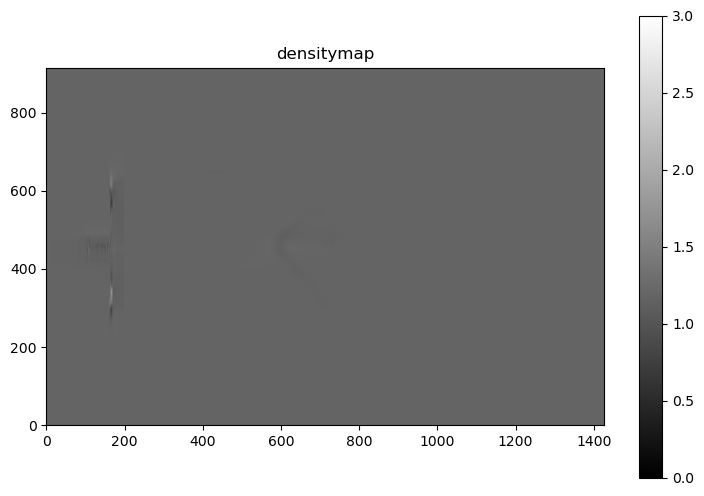

ヒートマップの表示


In [ ]:
middle_index=int((density.shape[1])/2)
density_s=density[:,middle_index,:]
density_s_wide=np.rot90(np.array(density_s.cpu()),1)
print(density_s_wide.shape)

def plot_showandsave(array,path,name):
    # ヒートマップを作成
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6)) # 図の設定
        #c = ax.pcolor(array, cmap='binary_r') # ヒートマップ
        c = ax.pcolor(array, cmap='binary_r',norm=Normalize(vmin=0, vmax=3)) # ヒートマップ


        ax.set_title(name) # タイトル
        ax.set_aspect('equal', adjustable='box') # アスペクト比
        fig.colorbar(c, ax=ax) # カラーバー
        plt.savefig("{}\{}".format(path,name))#画像の保存
        print("ヒートマップの保存")
        plt.show() # 図を表示
        print("ヒートマップの表示")

plot_showandsave(density_s_wide,"density","densitymap")

In [ ]:
density_s

tensor([[1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
        [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
        [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
        ...,
        [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
        [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780],
        [1.1780, 1.1780, 1.1780,  ..., 1.1780, 1.1780, 1.1780]],
       device='cuda:0')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

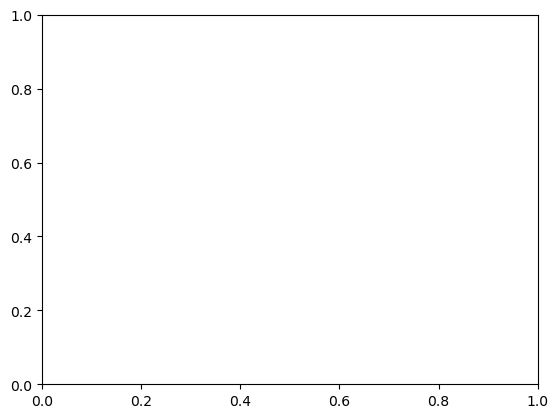

In [ ]:
plt.hist(density_s,density=True)
plt.xlim(0,2.5)
plt.show()